In [1]:
# numpy for linear algebra
import numpy as np

# matplotlib for plotting the loss functions and/or accuracy
import matplotlib.pyplot as plt

# confusion matrix
from sklearn.metrics import confusion_matrix

# accuracy score
from sklearn.metrics import accuracy_score

# show progress bar
from tqdm import tqdm

In [2]:
class Activation:

    def __init__(self, activation_type=None):
        if activation_type is None:
            self.activation_type = 'linear'
        else:
            self.activation_type = activation_type

    def linear(self, x):
        return x

    def d_linear(self, x):
        return np.ones(x.shape)

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1-self.sigmoid(x))
     
    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def d_tanh(self, x):
        return 1-(self.tanh(x))**2

    def ReLU(self, x):
        return x * (x > 0)

    def d_ReLU(self, x):
        return (x>0)*np.ones(x.shape)

    def PReLU(self, x, alpha=0.2):
        return np.where(x > 0, x, alpha*x) 

    def d_PReLU(self, x, alpha=0.2):
        return np.where(x > 0, 1, alpha) 

    def softmax(self, x):
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        return softmax

    def d_softmax(self, x):
        if len(x.shape)==1:
            x = np.array(x).reshape(1,-1)
        else:
            x = np.array(x)
        m, d = x.shape
        a = self.softmax(x)
        tensor1 = np.einsum('ij,ik->ijk', a, a)
        tensor2 = np.einsum('ij,jk->ijk', a, np.eye(d, d))
        return tensor2 - tensor1

    def get_activation(self, x):
        if self.activation_type == 'sigmoid':
            return self.sigmoid(x)
        elif self.activation_type == 'tanh':
            return self.tanh(x)
        elif self.activation_type == 'relu':
            return self.ReLU(x)
        elif self.activation_type == 'linear':
            return self.linear(x)
        elif self.activation_type == 'prelu':
            return self.PReLU(x)
        elif self.activation_type == 'softmax':
            return self.softmax(x)
        else:
            raise ValueError("Valid Activations are only 'sigmoid', 'linear', 'tanh' 'softmax', 'prelu' and 'relu'")

    def get_d_activation(self, x):
        if self.activation_type == 'sigmoid':
            return self.d_sigmoid(x)
        elif self.activation_type == 'tanh':
            return self.d_tanh(x)
        elif self.activation_type == 'relu':
            return self.d_ReLU(x)
        elif self.activation_type == 'linear':
            return self.d_linear(x)
        elif self.activation_type == 'prelu':
            return self.d_PReLU(x)
        elif self.activation_type == 'softmax':
            return self.d_softmax(x)
        else:
            raise ValueError("Valid Activations are only 'sigmoid', 'linear', 'tanh', 'softmax', 'prelu' and 'relu'")

    def forward(self, X):
        self.X = X
        z = self.get_activation(X)
        return z
    
    def backpropagation(self, dz):
        f_prime = self.get_d_activation(self.X)
        if self.activation_type=='softmax':
            # because derivative of softmax is a tensor
            dx = np.einsum('ijk,ik->ij', f_prime, dz)
        else:
            dx = dz * f_prime
        return dx

In [3]:
class Cost:

    def __init__(self, cost_type='mse'):
        self.cost_type = cost_type

    def mse(self, a, y):
        return (1/2)*np.sum((np.linalg.norm(a-y, axis=1))**2)

    def d_mse(self, a, y):
        return a - y

    def cross_entropy(self, a, y, epsilon=1e-12):
        a = np.clip(a, epsilon, 1. - epsilon)
        return -np.sum(y*np.log(a))

    def d_cross_entropy(self, a, y, epsilon=1e-12):
        a = np.clip(a, epsilon, 1. - epsilon)
        return -y/a

    def get_cost(self, a, y):
        if self.cost_type == 'mse':
            return self.mse(a, y)
        elif self.cost_type == 'cross-entropy':
            return self.cross_entropy(a, y)
        else:
            raise ValueError("Valid cost functions are only 'mse', and 'cross-entropy'")

    def get_d_cost(self, a, y):
        if self.cost_type == 'mse':
            return self.d_mse(a, y)
        elif self.cost_type == 'cross-entropy':
            return self.d_cross_entropy(a, y)
        else:
            raise ValueError("Valid cost functions are only 'mse', and 'cross-entropy'")

In [5]:
class Optimizer:

    def __init__(self, optimizer_type=None, shape_W=None, shape_b=None,
                 momentum1=0.9, momentum2=0.999, epsilon=1e-8):
        if optimizer_type is None:
            self.optimizer_type = 'adam'
        else:
            self.optimizer_type = optimizer_type

        self.momentum1 = momentum1
        self.momentum2 = momentum2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW, db, k):
        return dW, db
 
    def SGD(self, dW, db, k):
        self.vdW = self.momentum1*self.vdW + (1-self.momentum1)*dW
        self.vdb = self.momentum1*self.vdb + (1-self.momentum1)*db

        return self.vdW, self.vdb

    def RMSProp(self, dW, db, k):
        self.SdW = self.momentum2*self.SdW + (1-self.momentum2)*(dW**2)
        self.Sdb = self.momentum2*self.Sdb + (1-self.momentum2)*(db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW/den_W, db/den_b
 
    def Adam(self, dW, db, k):
        # momentum
        self.vdW = self.momentum1*self.vdW + (1-self.momentum1)*dW
        self.vdb = self.momentum1*self.vdb + (1-self.momentum1)*db

        # rmsprop
        self.SdW = self.momentum2*self.SdW + (1-self.momentum2)*(dW**2)
        self.Sdb = self.momentum2*self.Sdb + (1-self.momentum2)*(db**2)

        # correction
        if k>1:
            vdW_h = self.vdW / (1-(self.momentum1**k))
            vdb_h = self.vdb / (1-(self.momentum1**k))
            SdW_h = self.SdW / (1-(self.momentum2**k))
            Sdb_h = self.Sdb / (1-(self.momentum2**k))
        else:
            vdW_h = self.vdW 
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h/den_W, vdb_h/den_b

    def get_optimization(self, dW, db, k):
        if self.optimizer_type == 'gd':
            return self.GD(dW, db, k)
        if self.optimizer_type == 'sgd':
            return self.SGD(dW, db, k)
        if self.optimizer_type == 'rmsprop':
            return self.RMSProp(dW, db, k)
        if self.optimizer_type == 'adam':
            return self.Adam(dW, db, k)
        else:
            raise ValueError("Valid optimizer options are only 'gd', 'sgd', 'rmsprop', and 'adam'.")

In [6]:
class LearningRateDecay:

    def __init__(self):
        pass

    def constant(self, t, lr_0):
        return lr_0

    def time_decay(self, t, lr_0, k):
        lr = lr_0 /(1+(k*t))
        return lr

    def step_decay(self, t, lr_0, F, D):
        mult = F**np.floor((1+t)/D)
        lr = lr_0 * mult
        return lr

    def exponential_decay(self, t, lr_0, k):
        lr = lr_0 * np.exp(-k*t)
        return lr

In [7]:
class Utility:

    def __init__(self):
        pass

    def label_encoding(self, Y):
        idx_list = []
        result = []
        for col in range(Y.shape[1]):
            indexes = {val: idx for idx, val in enumerate(np.unique(Y[:, col]))}
            result.append([indexes[s] for s in Y[:, col]])
            idx_list.append(indexes)
        return np.array(result).T, idx_list

    def onehot(self, X):
        indexes = {val: idx for idx, val in enumerate(np.unique(X))}
        y = np.array([indexes[s] for s in X])
        X_onehot = np.zeros((y.size, len(indexes)))
        X_onehot[np.arange(y.size), y] = 1
        return X_onehot, indexes

    def minmax(self, X, min_X=None, max_X=None):
        if min_X is None:
            min_X = np.min(X, axis=0)
        if max_X is None:
            max_X = np.max(X, axis=0)
        Z = (X - min_X) / (max_X - min_X)
        return Z, min_X, max_X

    def standardize(self, X, mu=None, std=None):
        if mu is None:
            mu = np.mean(X, axis=0)
        if std is None:
            std = np.std(X, axis=0)
        Z = (X - mu) / std
        return Z, mu, std

    def inv_standardize(self, Z, mu, std):
        X = Z*std + mu
        return X

    def train_test_split(self, X, y, test_ratio=0.2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        train_ratio = 1-test_ratio
        indices = np.random.permutation(X.shape[0])
        train_idx, test_idx = indices[:int(train_ratio*len(X))], indices[int(train_ratio*len(X)):]
        X_train, X_test = X[train_idx,:], X[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
        return X_train, X_test, y_train, y_test

In [8]:
class Weights_initializer:

    def __init__(self, shape, initializer_type=None, seed=None):
        self.shape = shape
        if initializer_type is None:
            self.initializer_type = "he_normal"
        else:
            self.initializer_type = initializer_type
        self.seed = seed
        
    def zeros_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.zeros(self.shape)

    def ones_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.ones(self.shape)

    def random_normal_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.random.normal(size=self.shape)

    def random_uniform_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def he_initializer(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(2/Kh)

    def xavier_initializer(self):
        '''
        shape: Shape of the Kernel matrix.
        '''
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(1/Kh)

    def glorot_initializer(self):
        '''
        shape: Shape of the weight matrix.
        '''
        if self.seed is not None:
            np.random.seed(self.seed)
        try:
            F, Kc, Kh, Kw = self.shape
        except:
            Kh, Kw = self.shape
        return np.random.randn(*self.shape) * np.sqrt(2/(Kh+Kw))

    def get_initializer(self):
        if self.initializer_type == 'zeros':
            return self.zeros_initializer()
        elif self.initializer_type == 'ones':
            return self.ones_initializer()
        elif self.initializer_type == 'random_normal':
            return self.random_normal_initializer()
        elif self.initializer_type == 'random_uniform':
            return self.random_uniform_initializer()
        elif self.initializer_type == 'he_normal':
            return self.he_initializer()
        elif self.initializer_type == 'xavier_normal':
            return self.xavier_initializer()
        elif self.initializer_type == 'glorot_normal':
            return self.glorot_initializer()
        else:
            raise ValueError("Valid initializer options are 'zeros', 'ones', 'random_normal', 'random_uniform', 'he_normal', 'xavier_normal', and 'glorot_normal'")

In [9]:
class Dense:

    def __init__(self, neurons, activation_type=None, use_bias=True, 
                 weight_initializer_type=None, weight_regularizer=None, seed=None, input_dim=None):

        self.neurons = neurons
        self.activation = Activation(activation_type=activation_type)
        self.use_bias = use_bias
        self.weight_initializer_type = weight_initializer_type # none is handled
        if weight_regularizer is None:
            self.weight_regularizer = ('L2', 0)
        else:
            self.weight_regularizer = weight_regularizer
        self.seed = seed
        self.input_dim = input_dim


    def initialize_parameters(self, hl, optimizer_type):
        shape_W = (hl, self.neurons)
        shape_b = (self.neurons, 1)
        initializer = Weights_initializer(shape=shape_W,
                                          initializer_type=self.weight_initializer_type,
                                          seed=self.seed)
        self.W = initializer.get_initializer()
        self.b = np.zeros(shape_b)
        
        self.optimizer = Optimizer(optimizer_type=optimizer_type, shape_W=shape_W, shape_b=shape_b)

    def forward(self, X):
        self.X = X
        r = X @ self.W
        self.z = r + self.b.T
        a = self.activation.forward(self.z)
        return a
    
    def backpropagation(self, da):
        dz = self.activation.backpropagation(da)
        dr = dz.copy()
        self.db = np.sum(dz, axis=0).reshape(-1,1)
        self.dW = (self.X.T) @ dr
        dX = dr @ (self.W.T)
        return dX

    def update(self, lr, m, k):
        dW, db = self.optimizer.get_optimization(self.dW, self.db, k)

        if self.weight_regularizer[0].lower()=='l2':
            dW += self.weight_regularizer[1] * self.W
        elif self.weight_regularizer[0].lower()=='l1':
            dW += self.weight_regularizer[1] * np.sign(self.W)
        
        self.W -= dW*(lr/m)
        if self.use_bias:
            self.b -= db*(lr/m)

In [10]:
class Dropout:

    def __init__(self, p):
        self.p = p
        if self.p == 0:
            self.p += 1e-6
        if self.p == 1:
            self.p -= 1e-6
    
    def forward(self, X):
        self.mask = (np.random.rand(*X.shape) < self.p) / self.p 
        Z = X * self.mask
        return Z
    
    def backpropagation(self, dZ):
        dX = dZ * self.mask
        return dX

In [11]:
class BatchNormalization:

    def __init__(self, momentum=0.9, epsilon=1e-6):
        self.epsilon = epsilon
        self.momentum = momentum
    
    def initialize_parameters(self, d):
        self.gamma = np.ones((d))
        self.beta = np.zeros((d))
        self.running_mean = np.zeros((d))
        self.running_var = np.zeros((d))
    
    def forward(self, z, mode='train'):
        if mode=='train':
            self.m, self.d = z.shape
            self.mu = np.mean(z, axis = 0) # 𝜇
            self.var = np.var(z, axis=0) # 𝜎^2
            self.zmu = z - self.mu # z - 𝜇
            self.ivar = 1 / np.sqrt(self.var + self.epsilon) # 𝜎𝑖𝑛𝑣
            self.zhat = self.zmu * self.ivar 
            q = self.gamma*self.zhat + self.beta # ql
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        elif mode=='test':
            q = (z - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            q = self.gamma*q + self.beta
        else:
            raise ValueError('Invalid forward batchnorm mode "%s"' % mode)
        return q

    def backpropagation(self, dq):
        self.dgamma = np.sum(dq * self.zhat, axis=0)
        self.dbeta = np.sum(dq, axis=0)
        dzhat = dq * self.gamma
        dvar = np.sum(dzhat * self.zmu * (-.5) * (self.ivar**3), axis=0)
        dmu = np.sum(dzhat * (-self.ivar), axis=0)
        dz = dzhat * self.ivar + dvar * (2/self.m) * self.zmu + (1/self.m)*dmu
        return dz

    def update(self, lr, m, k):
        self.gamma -= self.dgamma*(lr/m)
        self.beta -= self.dbeta*(lr/m)

In [12]:
class Padding2D:

    def __init__(self, p='valid'):
        self.p = p
        
    def get_dimensions(self, input_shape, kernel_size, s=(1,1)):
        if len(input_shape)==4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape)==3:
            Nc, Nh, Nw = input_shape
        
        Kh, Kw = kernel_size
        sh, sw = s
        p = self.p
        
        if type(p)==int:
            pt, pb = p, p
            pl, pr = p, p

        if type(p)==tuple:
            ph, pw = p
            pt, pb = ph//2, (ph+1)//2
            pl, pr = pw//2, (pw+1)//2

        elif p=='valid':
            pt, pb = 0, 0
            pl, pr = 0, 0

        elif p=='same':
            # calculating how much padding is required in all 4 directions 
            # (top, bottom, left and right)
            ph = (sh-1)*Nh + Kh - sh
            pw = (sw-1)*Nw + Kw - sw

            pt, pb = ph//2, (ph+1)//2
            pl, pr = pw//2, (pw+1)//2

        else:
            raise ValueError("Incorrect padding type. Allowed types are only 'same', 'valid', an integer or a tuple of length 2.")
            
        if len(input_shape)==4:
            output_shape = (m, Nc, Nh+pt+pb, Nw+pl+pr)
        elif len(input_shape)==3:
            output_shape = (Nc, Nh+pt+pb, Nw+pl+pr)
        
        return output_shape, (pt, pb, pl, pr)
        
    def forward(self, X, kernel_size, s=(1,1)):
        self.input_shape = X.shape
        m, Nc, Nh, Nw = self.input_shape
        
        self.output_shape, (self.pt, self.pb, self.pl, self.pr) = self.get_dimensions(self.input_shape, 
                                                                                      kernel_size, s=s)
        
        zeros_r = np.zeros((m, Nc, Nh, self.pr))
        zeros_l = np.zeros((m, Nc, Nh, self.pl))
        zeros_t = np.zeros((m, Nc, self.pt, Nw + self.pl + self.pr))
        zeros_b = np.zeros((m, Nc, self.pb, Nw + self.pl + self.pr))

        Xp = np.concatenate((X, zeros_r), axis=3)
        Xp = np.concatenate((zeros_l, Xp), axis=3)
        Xp = np.concatenate((zeros_t, Xp), axis=2)
        Xp = np.concatenate((Xp, zeros_b), axis=2)
        
        return Xp
    
    def backpropagation(self, dXp):
        m, Nc, Nh, Nw = self.input_shape
        dX = dXp[:, :, self.pt:self.pt+Nh, self.pl:self.pl+Nw]
        return dX

In [13]:
class Conv2D:

    def __init__(self, filters, kernel_size, s=(1, 1), p='valid',
                 activation_type=None, use_bias=True, weight_initializer_type=None, 
                 kernel_regularizer=None, seed=None, input_shape=None):

        self.padding = Padding2D(p=p)
        
        self.F = filters
        
        self.input_shape_x = input_shape
        
        if type(kernel_size)==int:
            self.kernel_size = (kernel_size, kernel_size)
        elif type(kernel_size)==tuple and len(kernel_size)==2:
            self.kernel_size = kernel_size
            
        self.Kh, self.Kw  = self.kernel_size
        
        if type(s)==int:
            self.s = (s,s)
        elif type(s)==tuple and len(s)==2:
            self.s = s
        
        self.sh, self.sw = self.s
        
        self.activation = Activation(activation_type=activation_type)
        self.use_bias = use_bias
        self.weight_initializer_type = weight_initializer_type # none is handled
        if kernel_regularizer is None:
            self.kernel_regularizer = ('L2', 0)
        else:
            self.kernel_regularizer = kernel_regularizer
        self.seed = seed
        
    def get_dimensions(self, input_shape):
        
        self.input_shape_x = input_shape # (3D or 4D)
        
        # Padded X will be actual input to this Conv2D
        
        self.input_shape, _ = self.padding.get_dimensions(self.input_shape_x, 
                                                          self.kernel_size, self.s)
        
        if len(input_shape)==3:
            self.Nc, self.Nh, self.Nw = self.input_shape
        elif len(input_shape)==4:
            self.m, self.Nc, self.Nh, self.Nw = self.input_shape
        
        # Output shape
        self.Oh = (self.Nh - self.Kh)//self.sh + 1
        self.Ow = (self.Nw - self.Kw)//self.sw + 1
        
        if len(input_shape)==3:
            self.output_shape = (self.F, self.Oh, self.Ow)
        elif len(input_shape)==4:
            self.output_shape = (self.m, self.F, self.Oh, self.Ow)

    def initialize_parameters(self, input_shape, optimizer_type):
        
        self.get_dimensions(input_shape)
        
        shape_b = (self.F, self.Oh, self.Ow)
        
        shape_K = (self.F, self.Nc, self.Kh, self.Kw)
        
        initializer = Weights_initializer(shape=shape_K,
                                          initializer_type=self.weight_initializer_type,
                                          seed=self.seed)
        
        self.K = initializer.get_initializer()
        self.b = np.zeros(shape_b)
        
        self.optimizer = Optimizer(optimizer_type=optimizer_type, shape_W=shape_K, shape_b=shape_b)
    
    def dilate2D(self, X, Dr=(1,1)):
        dh, dw = Dr # Dilate rate
        m, C, H, W = X.shape
        Xd = np.insert(arr=X, obj=np.repeat(np.arange(1,W), dw-1), values=0, axis=-1)
        Xd = np.insert(arr=Xd, obj=np.repeat(np.arange(1,H), dh-1), values=0, axis=-2)
        return Xd

    def prepare_subMatrix(self, X, Kh, Kw, s):
        m, Nc, Nh, Nw = X.shape
        sh, sw = s

        Oh = (Nh-Kh)//sh + 1
        Ow = (Nw-Kw)//sw + 1

        strides = (Nc*Nh*Nw, Nw*Nh, Nw*sh, sw, Nw, 1)
        strides = tuple(i * X.itemsize for i in strides)

        subM = np.lib.stride_tricks.as_strided(X, 
                                               shape=(m, Nc, Oh, Ow, Kh, Kw),
                                               strides=strides)

        return subM
         
    def convolve(self, X, K, s=(1,1), mode='front'):

        F, Kc, Kh, Kw = K.shape
        subM = self.prepare_subMatrix(X, Kh, Kw, s)
        
        if mode=='front':
            return np.einsum('fckl,mcijkl->mfij', K, subM)
        elif mode=='back':
            return np.einsum('fdkl,mcijkl->mdij', K, subM)
        elif mode=='param':
            return np.einsum('mfkl,mcijkl->fcij', K, subM)

    def dZ_D_dX(self, dZ_D, Nh, Nw):

        # Pad the dilated dZ (dZ_D -> dZ_Dp)

        _, _, Hd, Wd = dZ_D.shape

        ph = Nh - Hd + self.Kh - 1
        pw = Nw - Wd + self.Kw - 1
        
        padding_back = Padding2D(p=(ph, pw))

        dZ_Dp = padding_back.forward(dZ_D, self.kernel_size, self.s)

        # Rotate K by 180 degrees
        
        K_rotated = self.K[:, :, ::-1, ::-1]
        
        # convolve dZ_Dp with K_rotated
        
        dXp = self.convolve(dZ_Dp, K_rotated, mode='back')
        
        dX = self.padding.backpropagation(dXp)

        return dX

    def forward(self, X):
        # padding

        self.X = X

        Xp = self.padding.forward(X, self.kernel_size, self.s)
        
        # convolve Xp with K
        Z = self.convolve(Xp, self.K, self.s) + self.b
    
        a = self.activation.forward(Z)
        
        return a
     
    def backpropagation(self, da):

        Xp = self.padding.forward(self.X, self.kernel_size, self.s)

        m, Nc, Nh, Nw = Xp.shape

        dZ = self.activation.backpropagation(da)
        
        # Dilate dZ (dZ-> dZ_D)
        
        dZ_D = self.dilate2D(dZ, Dr=self.s)
        
        dX = self.dZ_D_dX(dZ_D, Nh, Nw)
        
        # Gradient dK
        
        _, _, Hd, Wd = dZ_D.shape
        
        ph = self.Nh - Hd - self.Kh + 1
        pw = self.Nw - Wd - self.Kw + 1

        padding_back = Padding2D(p=(ph, pw))

        dZ_Dp = padding_back.forward(dZ_D, self.kernel_size, self.s)
        
        self.dK = self.convolve(Xp, dZ_Dp, mode='param')
        
        # Gradient db
        
        self.db = np.sum(dZ, axis=0)
        
        return dX

    def update(self, lr, m, k):
        dK, db = self.optimizer.get_optimization(self.dK, self.db, k)

        if self.kernel_regularizer[0].lower()=='l2':
            dK += self.kernel_regularizer[1] * self.K
        elif self.weight_regularizer[0].lower()=='l1':
            dK += self.kernel_regularizer[1] * np.sign(self.K)

        self.K -= self.dK*(lr/m)
        
        if self.use_bias:
            self.b -= self.db*(lr/m)

In [14]:
class Pooling2D:

    def __init__(self, pool_size=(2,2), s=(2,2), p='valid', pool_type='max'):
        self.padding = Padding2D(p=p)
        
        if type(pool_size)==int:
            self.pool_size = (pool_size, pool_size)
        elif type(pool_size)==tuple and len(pool_size)==2:
            self.pool_size = pool_size
            
        self.Kh, self.Kw  = self.pool_size
        
        if type(s)==int:
            self.s = (s,s)
        elif type(s)==tuple and len(s)==2:
            self.s = s
        
        self.sh, self.sw = self.s
        
        self.pool_type = pool_type    

    def get_dimensions(self, input_shape):
        
        if len(input_shape)==4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape)==3:
            Nc, Nh, Nw = input_shape

        Oh = (Nh-self.Kh)//self.sh + 1
        Ow = (Nw-self.Kw)//self.sw + 1
        
        if len(input_shape)==4:
            self.output_shape = (m, Nc, Oh, Ow)
        elif len(input_shape)==3:
            self.output_shape = (Nc, Oh, Ow)

    def prepare_subMatrix(self, X, pool_size, s):
        m, Nc, Nh, Nw = X.shape
        sh, sw = s
        Kh, Kw = pool_size

        Oh = (Nh-Kh)//sh + 1
        Ow = (Nw-Kw)//sw + 1

        strides = (Nc*Nh*Nw, Nh*Nw, Nw*sh, sw, Nw, 1)
        strides = tuple(i * X.itemsize for i in strides)

        subM = np.lib.stride_tricks.as_strided(X, 
                                               shape=(m, Nc, Oh, Ow, Kh, Kw),
                                               strides=strides)
        return subM
    
    def pooling(self, X, pool_size=(2,2), s=(2,2)):
        
        subM = self.prepare_subMatrix(X, pool_size, s)
        
        if self.pool_type=='max':
            return np.max(subM, axis=(-2,-1))
        elif self.pool_type=='mean':
            return np.mean(subM, axis=(-2,-1))
        else:
            raise ValueError("Allowed pool types are only 'max' or 'mean'.")

    def prepare_mask(self, subM, Kh, Kw):
        
        m, Nc, Oh, Ow, Kh, Kw = subM.shape

        a = subM.reshape(-1,Kh*Kw)
        idx = np.argmax(a, axis=1)
        b = np.zeros(a.shape)
        b[np.arange(b.shape[0]), idx] = 1
        mask = b.reshape((m, Nc, Oh, Ow, Kh, Kw))

        return mask

    def mask_dXp(self, mask, Xp, dZ, Kh, Kw):
        dA = np.einsum('i,ijk->ijk', dZ.reshape(-1), mask.reshape(-1,Kh,Kw)).reshape(mask.shape)
        m, Nc, Nh, Nw = Xp.shape
        strides = (Nc*Nh*Nw, Nh*Nw, Nw, 1)
        strides = tuple(i * Xp.itemsize for i in strides)
        dXp = np.lib.stride_tricks.as_strided(dA, Xp.shape, strides)
        return dXp
            
    def maxpool_backprop(self, dZ, X):
        
        Xp = self.padding.forward(X, self.pool_size, self.s)

        subM = self.prepare_subMatrix(Xp, self.pool_size, self.s)

        m, Nc, Oh, Ow, Kh, Kw = subM.shape
        
        m, Nc, Nh, Nw = Xp.shape

        mask = self.prepare_mask(subM, Kh, Kw)
        
        dXp = self.mask_dXp(mask, Xp, dZ, Kh, Kw)
        
        return dXp

    def dZ_dZp(self, dZ):
        sh, sw = self.s
        Kh, Kw = self.pool_size

        dZp = np.kron(dZ, np.ones((Kh,Kw), dtype=dZ.dtype)) # similar to repelem in matlab

        jh, jw = Kh-sh, Kw-sw # jump along height and width

        if jw!=0:
            L = dZp.shape[-1]-1

            l1 = np.arange(sw, L)
            l2 = np.arange(sw + jw, L + jw)

            mask = np.tile([True]*jw + [False]*jw, len(l1)//jw).astype(bool)

            r1 = l1[mask[:len(l1)]]
            r2 = l2[mask[:len(l2)]]

            dZp[:, :, :, r1] += dZp[:, :, :, r2]
            dZp = np.delete(dZp, r2, axis=-1)

        if jh!=0:
            L = dZp.shape[-2]-1

            l1 = np.arange(sh, L)
            l2 = np.arange(sh + jh, L + jh)

            mask = np.tile([True]*jh + [False]*jh, len(l1)//jh).astype(bool)

            r1 = l1[mask[:len(l1)]]
            r2 = l2[mask[:len(l2)]]

            dZp[:, :, r1, :] += dZp[:, :, r2, :]
            dZp = np.delete(dZp, r2, axis=-2)

        return dZp

    def averagepool_backprop(self, dZ, X):
        
        Xp = self.padding.forward(X, self.pool_size, self.s)

        m, Nc, Nh, Nw = Xp.shape

        dZp = self.dZ_dZp(dZ)

        ph = Nh - dZp.shape[-2]
        pw = Nw - dZp.shape[-1]
        
        padding_back = Padding2D(p=(ph, pw))
        
        dXp = padding_back.forward(dZp, s=self.s, kernel_size=self.pool_size)

        return dXp / (Nh*Nw)

    def forward(self, X):
        self.X = X

        # padding
        Xp = self.padding.forward(X, self.pool_size, self.s)

        Z = self.pooling(Xp, self.pool_size, self.s)
        
        return Z
    
    def backpropagation(self, dZ):
        if self.pool_type=='max':
            dXp = self.maxpool_backprop(dZ, self.X)
        elif self.pool_type=='mean':
            dXp = self.averagepool_backprop(dZ, self.X)
        dX = self.padding.backpropagation(dXp)
        return dX

In [15]:
class Flatten:

    def __init__(self):
        pass

    def forward(self, X):
        self.m, self.Nc, self.Nh, self.Nw = X.shape
        X_flat = X.reshape((self.m, self.Nc * self.Nh * self.Nw))
        return X_flat
     
    def backpropagation(self, dZ):
        dX = dZ.reshape((self.m, self.Nc, self.Nh, self.Nw))
        return dX
    
    def get_dimensions(self, input_shape):
        
        if len(input_shape)==4:
            self.m, self.Nc, self.Nh, self.Nw = input_shape
        elif len(input_shape)==3:
            self.Nc, self.Nh, self.Nw = input_shape
        
        self.output_shape = self.Nc * self.Nh * self.Nw

In [16]:
class CNN:

    def __init__(self, layers=None):
        if layers is None:
            self.layers = []
        else:
            self.layers = layers
        self.network_architecture_called = False

    def add(self, layer):
        # adds a layer to CNN model
        self.layers.append(layer)

    def Input(self, input_shape):
        self.d = input_shape
        self.architecture = [self.d] # output architecture
        self.layer_name = ["Input"]
    
    def network_architecture(self):
        for layer in self.layers:
            if layer.__class__.__name__=='Conv2D':
                if layer.input_shape_x is not None:
                    self.Input(layer.input_shape_x)
                layer.get_dimensions(self.architecture[-1])
                self.architecture.append(layer.output_shape)
                self.layer_name.append(layer.__class__.__name__)
            elif layer.__class__.__name__ in ['Flatten', 'Pooling2D']:
                layer.get_dimensions(self.architecture[-1])
                self.architecture.append(layer.output_shape)
                self.layer_name.append(layer.__class__.__name__)
            elif layer.__class__.__name__=='Dense':
                self.architecture.append(layer.neurons)
                self.layer_name.append(layer.__class__.__name__)
            else:
                self.architecture.append(self.architecture[-1])
                self.layer_name.append(layer.__class__.__name__)

        self.layers = [layer for layer in self.layers if layer is not None]
        try:
            idx = model.layer_name.index("NoneType")
            del model.layer_name[idx]
            del model.architecture[idx]
        except:
            pass

    def summary(self):
        if self.network_architecture_called==False:
            self.network_architecture()
            self.network_architecture_called = True
        len_assigned = [45, 26, 15]
        count = {'Dense': 1, 'Activation': 1, 'Input': 1,
                'BatchNormalization': 1, 'Dropout': 1, 'Conv2D': 1,
                'Pooling2D': 1, 'Flatten': 1}

        col_names = ['Layer (type)', 'Output Shape', '# of Parameters']

        print("Model: CNN")
        print('-'*sum(len_assigned))

        text = ''
        for i in range(3):
            text += col_names[i] + ' '*(len_assigned[i]-len(col_names[i]))
        print(text)

        print('='*sum(len_assigned))

        total_params = 0
        trainable_params = 0
        non_trainable_params = 0

        for i in range(len(self.layer_name)):
            # layer name
            layer_name = self.layer_name[i]
            name = layer_name.lower() + '_' + str(count[layer_name]) + ' ' + '(' + layer_name + ')'
            count[layer_name] += 1

            # output shape
            try:
                out = '(None, ' 
                for n in range(len(model.architecture[i])-1):
                    out += str(model.architecture[i][n]) + ', '
                out += str(model.architecture[i][-1]) + ')'
            except:
                out = '(None, ' + str(self.architecture[i]) + ')'

            # number of params
            if layer_name=='Dense':
                h0 = self.architecture[i-1]
                h1 = self.architecture[i]
                if self.layers[i-1].use_bias:
                    params = h0*h1 + h1
                else:
                    params = h0*h1
                total_params += params
                trainable_params += params
            elif layer_name=='BatchNormalization':
                h = self.architecture[i]
                params = 4*h
                trainable_params += 2*h
                non_trainable_params += 2*h
                total_params += params
            elif layer_name=='Conv2D':
                layer = self.layers[i-1]
                if layer.use_bias:
                    add_b = 1
                else:
                    add_b = 0
                params = ((layer.Nc * layer.Kh * layer.Kw) + add_b) * layer.F
                trainable_params += params
                total_params += params
            else:
                # Pooling, Dropout, Flatten, Input
                params = 0
            names = [name, out, str(params)]

            # print this row
            text = ''
            for j in range(3):
                text += names[j] + ' '*(len_assigned[j]-len(names[j]))
            print(text)
            if i!=(len(self.layer_name)-1):
                print('-'*sum(len_assigned))
            else:
                print('='*sum(len_assigned))

        print("Total params:", total_params)
        print("Trainable params:", trainable_params)
        print("Non-trainable params:", non_trainable_params)
        print('-'*sum(len_assigned))

    def compile(self, cost_type, optimizer_type):
        self.cost = Cost(cost_type)
        self.cost_type = cost_type
        self.optimizer_type = optimizer_type

    def initialize_parameters(self):
        if self.network_architecture_called==False:
            self.network_architecture()
            self.network_architecture_called = True
        # initialize parameters for different layers
        for i, layer in enumerate(self.layers):
            if layer.__class__.__name__ in ['Dense', 'Conv2D']:
                layer.initialize_parameters(self.architecture[i], self.optimizer_type)
            elif layer.__class__.__name__=='BatchNormalization':
                layer.initialize_parameters(self.architecture[i])

    def fit(self, X, y, epochs=10, batch_size=5, lr=1, X_val=None, y_val=None, verbose=1, lr_decay=None, **kwargs):
        
        self.history = {'Training Loss': [],
                        'Validation Loss': [],
                        'Training Accuracy': [],
                        'Validation Accuracy': []}

        iterations = 0
        self.m = batch_size
        self.initialize_parameters()

        total_num_batches = np.ceil(len(X)/batch_size)

        for epoch in range(epochs):
            cost_train = 0
            num_batches = 0
            y_pred_train = []
            y_train = []
            
            print('\nEpoch: ' + str(epoch+1) + '/' + str(epochs))

            for i in tqdm(range(0, len(X), batch_size)):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                Z = X_batch.copy()

                # feed-forward
                for layer in self.layers:
                    Z = layer.forward(Z)

                # calculating training accuracy
                if self.cost_type=='cross-entropy':
                    y_pred_train += np.argmax(Z, axis=1).tolist()
                    y_train += np.argmax(y_batch, axis=1).tolist()
                
                # calculating the loss
                cost_train += self.cost.get_cost(Z, y_batch) / self.m

                # calculating dL/daL (last layer backprop error)
                dZ = self.cost.get_d_cost(Z, y_batch)
                
                # backpropagation
                for layer in self.layers[::-1]:
                    dZ = layer.backpropagation(dZ)

                # Parameters update
                for layer in self.layers:
                    if layer.__class__.__name__ in ['Dense', 'BatchNormalization', 'Conv2D']:
                        layer.update(lr, self.m, iterations)

                # Learning rate decay
                if lr_decay is not None:
                    lr = lr_decay(iterations, **kwargs)

                num_batches += 1
                iterations += 1
            
            cost_train /= num_batches

            # printing purpose only (Training Accuracy, Validation loss and accuracy)

            text  = 'Training Loss: ' + str(round(cost_train, 4)) + ' - '
            self.history['Training Loss'].append(cost_train)

            # training accuracy

            if self.cost_type=='cross-entropy':
                accuracy_train = np.sum(np.array(y_pred_train) == np.array(y_train)) / len(y_train)
                text += 'Training Accuracy: ' + str(round(accuracy_train, 4))
                self.history['Training Accuracy'].append(accuracy_train)
            else:
                text += 'Training Accuracy: ' + str(round(cost_train, 4))
                self.history['Training Accuracy'].append(cost_train)
            
            if X_val is not None:
                cost_val, accuracy_val = self.evaluate(X_val, y_val, batch_size)
                text += ' - Validation Loss: ' + str(round(cost_val, 4)) + ' - '
                self.history['Validation Loss'].append(cost_val)
                text += 'Validation Accuracy: ' + str(round(accuracy_val, 4))
                self.history['Validation Accuracy'].append(accuracy_val)

            if verbose:
                print(text)
            else:
                print()

    def evaluate(self, X, y, batch_size=None):
        
        if batch_size is None:
            batch_size = len(X)

        cost = 0
        correct = 0
        num_batches = 0
        utility = Utility()
        Y_1hot, _ = utility.onehot(y)

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            Y_1hot_batch = Y_1hot[i:i+batch_size]
            Z = X_batch.copy()
            for layer in self.layers:
                if layer.__class__.__name__=='BatchNormalization':
                    Z = layer.forward(Z, mode='test')
                else:
                    Z = layer.forward(Z)
            if self.cost_type=='cross-entropy':
                cost += self.cost.get_cost(Z, Y_1hot_batch) / len(y_batch)
                y_pred = np.argmax(Z, axis=1).tolist()
                correct += np.sum(y_pred == y_batch)
            else:
                cost += self.cost.get_cost(Z, y_batch) / len(y_batch)

            num_batches += 1

        if self.cost_type=='cross-entropy':
            accuracy = correct / len(y)
            cost /= num_batches
            return cost, accuracy
        else:
            cost /= num_batches
            return cost, cost

    def loss_plot(self):
        plt.plot(self.history['Training Loss'], 'k')
        if len(self.history['Validation Loss'])>0:
            plt.plot(self.history['Validation Loss'], 'r')
            plt.legend(['Train', 'Validation'], loc='upper right')
            plt.title('Model Loss')
        else:
            plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

    def accuracy_plot(self):
        plt.plot(self.history['Training Accuracy'], 'k')
        if len(self.history['Validation Accuracy'])>0:
            plt.plot(self.history['Validation Accuracy'], 'r')
            plt.legend(['Train', 'Validation'], loc='lower right')
            plt.title('Model Accuracy')
        else:
            plt.title('Training Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()

    def predict(self, X, batch_size=None):
        
        if batch_size==None:
            batch_size = len(X)

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            Z = X_batch.copy()
            for layer in self.layers:
                if layer.__class__.__name__=='BatchNormalization':
                    Z = layer.forward(Z, mode='test')
                else:
                    Z = layer.forward(Z)
            if i==0:
                if self.cost_type=='cross-entropy':
                    y_pred = np.argmax(Z, axis=1).tolist()
                else:
                    y_pred = Z
            else:
                if self.cost_type=='cross-entropy':
                    y_pred += np.argmax(Z, axis=1).tolist()
                else:
                    y_pred = np.vstack((y_pred, Z))
        
        return np.array(y_pred)
    def save_weights(self, file_path):
        weights_to_save = [layer.get_weights() for layer in self.layers]
        np.save(file_path, weights_to_save)

    def load_weights(self, file_path):
        loaded_weights = np.load(file_path, allow_pickle=True)
        for layer, weights in zip(self.layers, loaded_weights):
            layer.set_weights(weights)

In [17]:
import os
import cv2
import numpy as np


def load_data(dataset_path, image_size):
    classes= os.listdir(dataset_path)
    x_data=[]
    y_data=[]
    
    for class_index,class_name in enumerate(classes):
        class_path= os.path.join(dataset_path, class_name)
        images= os.listdir(class_path)
        
        for image_name in images:
            image_path= os.path.join(class_path,image_name)
            image= cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            image= cv2.resize(image,(image_size,image_size))
            x_data.append(image)
            y_data.append(class_index)
            
    x_data=np.array(x_data)
    y_data=np.array(y_data)
    return x_data, y_data

In [18]:
dataset_path= "C:\\Users\\91869\\Desktop\\cnn\\corn\\"
image_size= 32

x,y= load_data(dataset_path,image_size)

In [19]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=123)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

X_train = X_train/255
X_test = X_test/255

utility = Utility()


# train validation split
X_train_new, X_val, y_train_new, y_val = utility.train_test_split(X_train, y_train, test_ratio=0.2, seed=42)

Y_1hot_train, _ = utility.onehot(y_train_new)

input_shape = X_train_new.shape[1:]
output_dim = Y_1hot_train.shape[1]

input_shape, output_dim


((1, 32, 32), 4)

In [20]:
model = CNN()

model.add(model.Input(input_shape=input_shape))

model.add(Conv2D(16, kernel_size=(5, 5), p='same', activation_type="relu"))

model.add(Pooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), p='same', activation_type="relu"))

model.add(Pooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.4))

model.add(Dense(output_dim, activation_type="softmax"))

In [21]:
model.summary()

Model: CNN
--------------------------------------------------------------------------------------
Layer (type)                                 Output Shape              # of Parameters
input_1 (Input)                              (None, 1, 32, 32)         0              
--------------------------------------------------------------------------------------
conv2d_1 (Conv2D)                            (None, 16, 32, 32)        416            
--------------------------------------------------------------------------------------
pooling2d_1 (Pooling2D)                      (None, 16, 16, 16)        0              
--------------------------------------------------------------------------------------
conv2d_2 (Conv2D)                            (None, 32, 16, 16)        4640           
--------------------------------------------------------------------------------------
pooling2d_2 (Pooling2D)                      (None, 32, 8, 8)          0              
--------------------------------

In [22]:
batch_size = 256
epochs = 12
lr = 0.05

model.compile(cost_type="cross-entropy", optimizer_type="adam")

In [23]:
LR_decay = LearningRateDecay()

model.fit(X_train_new, Y_1hot_train, epochs=epochs, batch_size=batch_size, lr=lr, X_val=X_val, 
          y_val=y_val, verbose=1, lr_decay=LR_decay.constant, lr_0=lr)


Epoch: 1/12


100%|█████████████████████████████████████████████| 11/11 [27:20<00:00, 149.15s/it]


Training Loss: 15.3723 - Training Accuracy: 0.2987 - Validation Loss: 16.1287 - Validation Accuracy: 0.3213

Epoch: 2/12


100%|█████████████████████████████████████████████| 11/11 [26:23<00:00, 143.91s/it]


Training Loss: 15.7841 - Training Accuracy: 0.3146 - Validation Loss: 15.7875 - Validation Accuracy: 0.3357

Epoch: 3/12


100%|█████████████████████████████████████████████| 11/11 [25:52<00:00, 141.14s/it]


Training Loss: 14.6793 - Training Accuracy: 0.3525 - Validation Loss: 14.4571 - Validation Accuracy: 0.3804

Epoch: 4/12


100%|█████████████████████████████████████████████| 11/11 [27:10<00:00, 148.26s/it]


Training Loss: 13.4877 - Training Accuracy: 0.3943 - Validation Loss: 12.1903 - Validation Accuracy: 0.4409

Epoch: 5/12


100%|█████████████████████████████████████████████| 11/11 [26:06<00:00, 142.45s/it]


Training Loss: 12.0848 - Training Accuracy: 0.4376 - Validation Loss: 12.281 - Validation Accuracy: 0.4424

Epoch: 6/12


100%|██████████████████████████████████████████████| 11/11 [09:58<00:00, 54.39s/it]


Training Loss: 11.4568 - Training Accuracy: 0.4603 - Validation Loss: 11.3287 - Validation Accuracy: 0.4539

Epoch: 7/12


100%|██████████████████████████████████████████████| 11/11 [09:57<00:00, 54.32s/it]


Training Loss: 11.0524 - Training Accuracy: 0.4614 - Validation Loss: 10.5779 - Validation Accuracy: 0.4813

Epoch: 8/12


100%|██████████████████████████████████████████████| 11/11 [09:59<00:00, 54.47s/it]


Training Loss: 9.7727 - Training Accuracy: 0.4614 - Validation Loss: 9.0722 - Validation Accuracy: 0.4841

Epoch: 9/12


100%|██████████████████████████████████████████████| 11/11 [10:01<00:00, 54.72s/it]


Training Loss: 7.4966 - Training Accuracy: 0.4812 - Validation Loss: 6.5242 - Validation Accuracy: 0.451

Epoch: 10/12


100%|██████████████████████████████████████████████| 11/11 [10:15<00:00, 55.92s/it]


Training Loss: 4.2957 - Training Accuracy: 0.4867 - Validation Loss: 3.1885 - Validation Accuracy: 0.4928

Epoch: 11/12


100%|██████████████████████████████████████████████| 11/11 [09:56<00:00, 54.26s/it]


Training Loss: 2.7547 - Training Accuracy: 0.5004 - Validation Loss: 2.4989 - Validation Accuracy: 0.4914

Epoch: 12/12


100%|██████████████████████████████████████████████| 11/11 [10:09<00:00, 55.44s/it]


Training Loss: 2.5585 - Training Accuracy: 0.4971 - Validation Loss: 2.6555 - Validation Accuracy: 0.4798


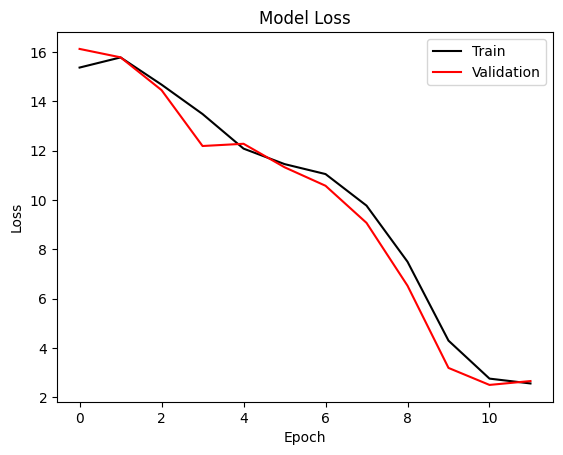

In [24]:
model.loss_plot()

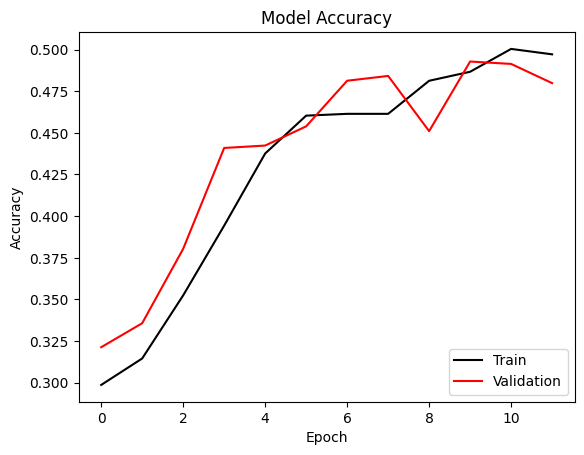

In [25]:
model.accuracy_plot()

In [26]:
y_pred = model.predict(X_test, batch_size=batch_size)
confusion_matrix(y_test, y_pred)

array([[112,   2,   3,   1],
       [  8,  12,   9,  12],
       [ 21,  21,  40,  36],
       [ 17,  20,  37,  35]], dtype=int64)

In [27]:
acc = accuracy_score(y_test, y_pred)
print('Error Rate =',round((1-acc)*100, 2))
print('Accuracy =',round((acc)*100, 2))

Error Rate = 48.45
Accuracy = 51.55
